# Airbnb Data Science Project

### 3 Questions to explore:

- What neighborhoods have the best value for money?
- What factors impact price per lodging?
- What factors impact rating on lodgings?

In [433]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

listings = pd.read_csv('listings.csv')
listings_2 = listings.copy()
listings_2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

#### First Question: What neighborhoods have the best ratings relative to price?

In [434]:
#first we need to clean up the price column... it looks like a lot of the price column entries are objects
#consluted this site: https://pbpython.com/currency-cleanup.html

listings_2['price'].apply(type).value_counts()

#good news... we confirmed that they are all strings and we dont have a situtation where there is a mix in entries...
#so we are dealing with all strings... 


<class 'str'>    3585
Name: price, dtype: int64

In [435]:
#remove strange commas and currency symbols from entries and convert the string objects to floats
def clean_price_column(df, column='price'):
    df[column] = df[column].str.replace(',','')
    df[column] = df[column].str.replace('$','')
    df[column] = df[column].astype('float')

clean_price_column(listings_2)



In [436]:
#check to make sure that the new price column is how we'd like it to be...
listings_2['price'].describe()


count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

In [437]:
#create a simpler df to help answer the first question
neighborhoods = listings_2[['neighbourhood_cleansed','price', 'review_scores_rating','number_of_reviews']]
neighborhoods.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  3585 non-null   object 
 1   price                   3585 non-null   float64
 2   review_scores_rating    2772 non-null   float64
 3   number_of_reviews       3585 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 112.2+ KB


In [438]:
#remove nans from host neighborhood
neighborhoods = neighborhoods.dropna(subset=['neighbourhood_cleansed'],axis=0)
neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 3584
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  3585 non-null   object 
 1   price                   3585 non-null   float64
 2   review_scores_rating    2772 non-null   float64
 3   number_of_reviews       3585 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 140.0+ KB


In [439]:
#we probably shouldn't include neighborhoods that don't meet a minimum threshold of reviews, say 100..
a = neighborhoods.groupby('neighbourhood_cleansed').number_of_reviews.sum()
b = pd.DataFrame(a).reset_index()
b['neighbourhood_cleansed'].describe()

count          25
unique         25
top       Allston
freq            1
Name: neighbourhood_cleansed, dtype: object

In [440]:
#let's adjust our dataframe by host_neighborhood to see how averaeg price / ratings stack up
#consulted: https://jamesrledoux.com/code/group-by-aggregate-pandas
top_neighborhoods = neighborhoods.groupby('neighbourhood_cleansed').agg({'price': 'mean', 'review_scores_rating': 'mean', 'number_of_reviews': 'sum'}).sort_values(by=['review_scores_rating'], ascending=False)
top_neighborhoods = top_neighborhoods.reset_index()
top_neighborhoods.head()

,neighbourhood_cleansed,price,review_scores_rating,number_of_reviews
0,Leather District,253.600000,98.333333,69
1,Roslindale,98.428571,95.380000,1387
2,West Roxbury,107.108696,95.212121,690
3,South Boston Waterfront,306.060241,94.431034,744
4,Jamaica Plain,138.478134,94.159322,9055


In [441]:
#Let's ditch the the host neighbourhoods that aren't over the 100 threshold and rename the columns to mak
top_neighborhoods_cleaned = top_neighborhoods[top_neighborhoods['number_of_reviews']>=100]
top_neighborhoods_cleaned = top_neighborhoods_cleaned.sort_values(by=['review_scores_rating'], ascending=False).head(10)
top_neighborhoods_cleaned = top_neighborhoods_cleaned.set_index('neighbourhood_cleansed')
top_neighborhoods_cleaned = top_neighborhoods_cleaned.rename(columns={"price": "average_price", "review_scores_rating": "average_rating", "number_of_reviews": "total_reviews"})
top_neighborhoods_cleaned

,average_price,average_rating,total_reviews
neighbourhood_cleansed,,,
Roslindale,98.428571,95.380000,1387
West Roxbury,107.108696,95.212121,690
South Boston Waterfront,306.060241,94.431034,744
Jamaica Plain,138.478134,94.159322,9055
Longwood Medical Area,138.444444,94.000000,393
South Boston,187.609195,93.980392,3851
North End,195.678322,93.725000,4483
Charlestown,198.045045,93.697368,1981
Beacon Hill,224.443299,93.378698,4098


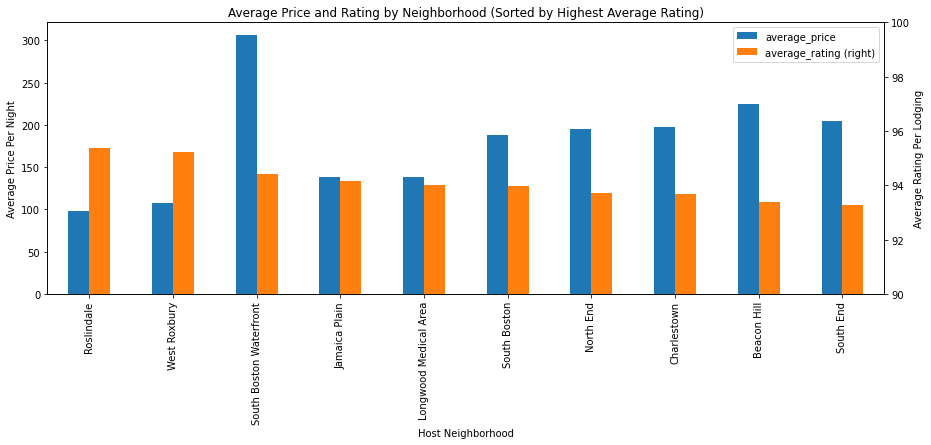

In [442]:
#let's make the visual for our blog post
top_neighborhoods_cleaned_chart = top_neighborhoods_cleaned.drop(columns=['total_reviews'])

base_color = sns.color_palette()[0]
ax = top_neighborhoods_cleaned_chart.plot(kind='bar', secondary_y='average_rating', figsize = (15,5))
ax.right_ax.set_ylim(90,100)

plt.title('Average Price and Rating by Neighborhood (Sorted by Highest Average Rating)')
ax.set_xlabel('Host Neighborhood')
ax.right_ax.set_ylabel('Average Rating Per Lodging')
ax.set_ylabel('Average Price Per Night')
plt.show()


###  Question 1 conclusion: If I were staying in Boston I would definitely try to find a place in West Roxbury or Roslindale to get the most value for price !!!

### Second Question:  What factors impact price per lodging??

In [443]:
#Because I am OCD let's create another DF Copy...
listings_3 = listings.copy()

In [444]:
#Right off the bat we know that we need to clean up the price column...
clean_price_column(listings_3)

In [445]:
#looking at columns that we can drop....

listings_3.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [446]:
listings_3.review_scores_rating.describe()

count    2772.000000
mean       91.916667
std         9.531686
min        20.000000
25%        89.000000
50%        94.000000
75%        98.250000
max       100.000000
Name: review_scores_rating, dtype: float64

In [447]:
def clean_data_for_linear_model(df, response_col, test_size=.3, rand_state=42): 
    """ INPUT: 
        pandas dataframe
   
        OUTPUT:
        X - A matrix holding all of the variables you want to consider when predicting the response
        y - the corresponding response vector
        test_score - float - r2 score on the test data
        train_score - float - r2 score on the test data
        lm_model - model object from sklearn
        X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
        
        Perform to obtain the correct X and y objects
        This function cleans df using the following steps to produce X and y:
        
        1. Drop all the rows with no price information
        2. Create price as the y object
        3. Drop irrelevant columns 
        4. For each numeric variable in X, fill the column with the mean value of the column.
        5. Create dummy columns for all the categorical variables in X, drop the original columns
        6. split X and Y into test and train variables
        7. instantiate the linear regression
        8. fit the model
        
        
    """
    
    #drop NANs from price and reviwes column
    df = df.dropna(subset=['price'], axis=0)
    df = df.dropna(subset=['review_scores_rating'], axis=0)
    #dropping irrelevant columns, that are about the host, only have one entry, or are all null
    df = df.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'host_url', 'country', 'host_picture_url', 'city', 'market', 'country_code', 'zipcode', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'smart_location', 'latitude', 'longitude', 'weekly_price', 'monthly_price', 'neighbourhood_group_cleansed', 'host_neighbourhood', 'host_id', 'host_name', 'host_since', 'host_location', 'host_about', 'host_listings_count', 'state', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood',], axis=1)
    #also get rid of the obviously text columns since I won't be doing any text evaluations(I'm still learning how to do that) as well as other not relevant columns 
    df = df.drop(['name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'host_thumbnail_url', 'transit', 'access', 'interaction', 'house_rules', 'last_review', 'amenities', 'first_review', 'last_review', 'calendar_updated', 'cleaning_fee', 'extra_people'], axis=1)
    #double check that columns with a majority of null data are excluded
    #shoutout: https://stackoverflow.com/questions/49791246/drop-columns-with-more-than-60-percent-of-empty-values-in-pandas
    df = df.dropna(thresh=df.shape[0]*0.5,how='all',axis=1)
    
    
    #fill mean for numerical variables in X
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    #create the dummy columns for categorical variables in X and drop the original columns
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in cat_vars:
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

    #create response col as the y object
    y = df[response_col]
    #Set new df = to X matrix
    X = df.drop(response_col, axis=1)
    
    
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state=rand_state)
    #Instantiate 
    lm_model = LinearRegression(normalize=True)
    #fit lines
    lm_model.fit(X_train, y_train)
    
    #predict
    #y_test_preds = lm.fit(X_test)
    #y_train_preds = lm.fit(X_train)
    
    #Score using your model
    #test_score = r2_score(y_test, y_test_preds)
    #train_score = r2_score(y_train, y_train_preds)
    
    return X, y, lm_model, X_train, X_test, y_train, y_test, df
    

X, y, lm_model, X_train, X_test, y_train, y_test, df = clean_data_for_linear_model(listings_3, 'price', test_size=.3, rand_state=42)


In [448]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772 entries, 1 to 3583
Columns: 188 entries, accommodates to require_guest_phone_verification_t
dtypes: float64(12), int64(10), uint8(166)
memory usage: 947.5 KB


In [449]:
#now let's see which variables have the highest coefficents...

def get_coefs_for_linear_model(coefficients, train_data):
    
    """INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    """
    
    coefs_df = pd.DataFrame()
    coefs_df['variable'] = train_data.columns
    coefs_df['coefficient'] = lm_model.coef_
    coefs_df = coefs_df.sort_values('coefficient', ascending=False).set_index('variable')
    return coefs_df
    
coefs_df = get_coefs_for_linear_model(lm_model.coef_, X_train)

In [450]:
coefs_df.head(10)

,coefficient
variable,
host_acceptance_rate_47%,9.804171e+15
host_acceptance_rate_40%,2.901699e+15
host_response_time_within a few hours,6.731641e+14
host_response_time_within an hour,6.731641e+14
host_response_time_within a day,6.731641e+14
host_acceptance_rate_30%,1.018191e+02
neighbourhood_cleansed_South Boston Waterfront,1.012728e+02
neighbourhood_cleansed_Back Bay,9.829997e+01
neighbourhood_cleansed_Beacon Hill,9.263269e+01


### What factors impact rating on lodgings?

In [454]:
#create variables and lm for review_scores_rating
X_2, y_2, lm_model_2, X_train_2, X_test_2, y_train_2, y_test_2, df_2 = clean_data_for_linear_model(listings_3, 'review_scores_rating', test_size=.3, rand_state=42)


In [452]:
#create df for coefficients for new lm
coefs_df_2 = get_coefs_for_linear_model(lm_model_2.coef_, X_train_2)

In [455]:
coefs_df_2.head(10)

,coefficient
variable,
host_acceptance_rate_47%,9.804171e+15
host_acceptance_rate_40%,2.901699e+15
host_response_time_within a few hours,6.731641e+14
host_response_time_within an hour,6.731641e+14
host_response_time_within a day,6.731641e+14
host_acceptance_rate_30%,1.018191e+02
neighbourhood_cleansed_South Boston Waterfront,1.012728e+02
neighbourhood_cleansed_Back Bay,9.829997e+01
neighbourhood_cleansed_Beacon Hill,9.263269e+01
